# Using Python BeautifulSoup to scrape DataCamp Tutorials & Analyze

In this tutorial, we are going to scrape the tutorials section of the DataCamp website and try to get some insights.

The insights will include but not limited to the following!

    Most contributing authors
    Timeline of contributors (How it all started!)
    Comparing upvotes vs. number of articles published
    
Before that, the website will be scraped using python's BeautifulSoup package.

To understand the page structure, Chrome browser developer tools will need to be used. This is done to identify the Classes that will be searched to get the required information. The following information will be gathered from the page:

    Author
    Publish Date
    Title
    Description
    Up Votes
    Importing Libraries

We'll start by importing the necessary libraries as follows:

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup

# Determining Pages to be Scraped

A sample URL that we're going to loop and scrape is the following https://www.datacamp.com/community/tutorials?page=2. As we can see, the page=2 argument changes for each page. In order to loop through all the pages to get the necessary dataset, we need to find out the number of pages.

The following lines of code do just that.

In [20]:
#1.
url = "https://www.datacamp.com/community/tutorials"
#2.
html = urlopen(url)
#3.
soup = BeautifulSoup(html, 'lxml')
#4.
pages = [i.text for i in soup.find_all('a') if 'community/tutorials?page=' in str(i)]
#5
lastpage = pages[-1]

In [21]:
print(lastpage)

24


The illustration is as follows:

    #1.Specified the url to a variable.
    #2.Opened the url using urlopen which was imported earlier.
    #3.Scraped the specified page and assigned it to soup variable.
    #4.Identified all hyperlinks on the page using list comprehension.  
    #5.filtered for those having community/tutorials?page= in it.
    
The text value of the last found url is the last page that needs to be scraped. 

### We proceed by declaring list variables that will hold the scraped values for the columns we intend as mentioned earlier.

In [22]:
description=[]
upvote=[]
author=[]
publishdate=[]
title=[]

## Doing the Actual Scrape

Now that we know how many pages we need to scrape and have declared our variables, we will now use a for loop and go through each page one by one to get our fields of interest as shown below. 

#### Note that we will end up having list of lists for each column of interest, but later we will be flattening the list further so that it can be used for Data Frames.

In [23]:
for cp in np.arange(1,int(lastpage)+1):
    url = "https://www.datacamp.com/community/tutorials?page=" + str(cp)
    html = urlopen(url)
    soup = BeautifulSoup(html, 'lxml')
    description.append([i.text for i in soup.find_all(class_='jsx-379356511 blocText description')])
    upvote.append([i.text for i in soup.find_all(class_='jsx-1972554161 normal')])
    author.append([i.text for i in soup.find_all(class_='jsx-566588255 name')])
    publishdate.append([i.text for i in soup.find_all(class_='jsx-566588255 date')])
    title.append([i.text for i in soup.find_all(class_='jsx-379356511 blue')])
    time.sleep(3)
print("Done!")

URLError: <urlopen error [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond>

Debugged
The code i changed is the class name of the upvote was not correct so i inspected from browsers and changed it.

### Here is what happened in the above code segment;

    Set the url to a variable
    Opened the url using urlopen which was imported earlier
    Scraped the specified page and assigned it to soup variable
    Identified and extracted values for 
        Description,
        Up Vote, 
        Author, 
        Publish Date, 
        Title 
by using their relevant class names. These class names were found using Developer Tools The time function has been used to be easy on the website this time :)


### Flattening List of Lists

Since the values we got are list of lists, they will now be flatted using the following code segment:

In [0]:
descriptionflat = [y for x in description for y in x]
upvoteflat = [y for x in upvote for y in x]
authorflat = [y for x in author for y in x]
publishdateflat = [y for x in publishdate for y in x]
titleflat = [y for x in title for y in x]
publishdateformatted = [datetime.strptime(re.sub('rd, ', ', ', re.sub('st, ', ', ', re.sub('nd, ', ', ', re.sub('th, ',', ',a)))), "%B %d, %Y") for a in publishdateflat]

The last statement in the cell above converts the date values (which are currently in String Format) to DateTime.

In [0]:
cdata = {"author":authorflat,"publishdate":publishdateformatted,"title":titleflat,"description":descriptionflat,"upvote":upvoteflat}
df = pd.DataFrame(data = cdata)
df.to_csv("c:\\users\\bisra\\documents\\datacamp130818.csv", header=True, index=False)

### Reading CSV File

Now we are attempting to read into the collected dataset from the CSV file we just created.

In [0]:
datacamp = pd.read_csv("c:\\users\\bisra\\documents\\datacamp130818.csv", parse_dates=["publishdate"], infer_datetime_format=True)

In [0]:
datacamp.shape

The above command tells us we're dealing with a dataset of 355 rows and 5 columns.

In [0]:
datacamp.head()

### Showing the first 5 rows of the dataset above using the head function.

In [0]:
datacamp['publishyymm'] = datacamp['publishdate'].dt.strftime("%Y-%b")
datacamp["posts"] = 1

#### The first line in the above code section creates a new column with the publish date formatted as a Year-Month format.

#### The second line assigns value 1 to a new column posts being used later.


## Tutorials Count by Time

Here we will organize the count of Tutorials over Timeline of Year and Month:

In [0]:
datacamp.groupby([datacamp['publishdate'].dt.year, datacamp['publishdate'].dt.month]).size().plot(kind='bar', figsize=(15,7), color='b')

In [0]:
<matplotlib.axes._subplots.AxesSubplot at 0x1bd55d2cb70>

## Since 2017 January

Since the duration from 2013 till 2016 represents very few posts, we will be ignoring them from now and considering posts starting Jan 2017. A filter will be applied for that as shown below


In [0]:
datacamp[datacamp["publishdate"]>='2017-01-01'].sort_values(by="publishdate", ascending=True).groupby([datacamp['publishyymm']],sort=False).size().plot(kind='bar', figsize=(15,7), color='b')

In [0]:
<matplotlib.axes._subplots.AxesSubplot at 0x1bd55ca57f0>

Tutorials have paced up in 2018 with especially starting March onwards with a consistent upwards pace. Since this data was pulled in mid-August and almost crossing the middle line of July's tutorials count, we might be having August as the month with highest posts so far this year!


## Top Authors Graph

While we're pacing up on all these tutorials, who have been contributing on them along the way? Here we go with a simple bar chart highlighting this very fact.

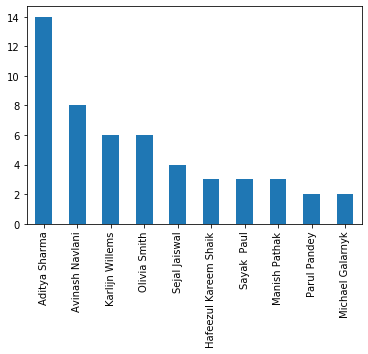

In [42]:
datacamp[datacamp["publishdate"]>='2017-01-01']["author"].value_counts(sort=True, ascending=False)[:10].plot(kind='bar')

In [0]:
<matplotlib.axes._subplots.AxesSubplot at 0x1bd57ca4ba8>

### Top Authors List

Let's build a list of these as well while we are at it. We'll be using this soon below:

In [0]:
topauthors = datacamp[datacamp["publishdate"]>='2017-01-01']["author"].value_counts(sort=True, ascending=False)[:10].index

In [41]:
topauthors

Index(['Aditya Sharma', 'Avinash Navlani', 'Karlijn Willems', 'Olivia Smith',
       'Sejal Jaiswal', 'Hafeezul Kareem Shaik', 'Sayak  Paul',
       'Manish Pathak', 'Parul Pandey', 'Michael Galarnyk'],
      dtype='object')

    This is what happened in the code section above.

    Limited Result set to Tutorials since 2017 January

    Select only Author field

    Aggregated results using the value_counts function

    Sorted the result set in descending order and limited it to the first 10 rows

### Tutorials Paced over Timeline

Now what we're going to focus on is since when and at what pace have these top 10 contributors been posting tutorials. For this, we will be using the list we just created along with some transformations to come up with a stacked bar chart that we need.

In [40]:
dh

,author,title,description,upvote,publishyymm,posts
publishdate,,,,,,
2019-06-28,Parul Pandey,Cluster Analysis in Tableau,Learn how to easily cluster your data in Table...,19,2019-Jun,1
2019-07-01,Hafeezul Kareem Shaik,f-string Formatting in Python,Learn about the f-string formatting technique ...,18,2019-Jul,1
2019-07-01,Aditya Sharma,Top Python IDEs for 2019,Curious about which Python environment is best...,37,2019-Jul,1
2019-07-08,Francisco Javier Carrera Arias,Conditional Functions in Spreadsheets,Learn when and how to use conditional function...,6,2019-Jul,1
2019-07-15,Avinash Navlani,Linear Programming with Spreadsheets,Learn how to use spreadsheets to solve linear ...,17,2019-Jul,1
2019-07-15,Olivia Smith,User Defined Stored Procedures in SQL,Learn how to use and apply the user-defined st...,9,2019-Jul,1
2019-07-19,Aditya Sharma,For Loops in Python,Learn how to implement For Loops in Python for...,30,2019-Jul,1
2019-07-23,Parul Pandey,SQL Interface within JupyterLab,Learn how to use and modify SQL tables within ...,33,2019-Jul,1
2019-07-23,Olivia Smith,GIT Push and Pull,Learn how to perform Git PUSH and PULL request...,18,2019-Jul,1


In [61]:
dh = datacamp[datacamp["publishdate"]>='2017-01-01'].sort_values(by="publishdate", ascending=True)
dh['publishdate'] = pd.to_datetime(dh.publishdate.astype(str).str[0:7]+'-01')

Debugged

Since the publish date is an index we can't perform any task on it so after we convert it to_date we can set it as an index 
as written below

In [62]:
dh = dh.set_index(["publishdate"])
dh

,author,title,description,upvote,publishyymm,posts
publishdate,,,,,,
2019-06-01,Parul Pandey,Cluster Analysis in Tableau,Learn how to easily cluster your data in Table...,19,2019-Jun,1
2019-07-01,Hafeezul Kareem Shaik,f-string Formatting in Python,Learn about the f-string formatting technique ...,18,2019-Jul,1
2019-07-01,Aditya Sharma,Top Python IDEs for 2019,Curious about which Python environment is best...,37,2019-Jul,1
2019-07-01,Francisco Javier Carrera Arias,Conditional Functions in Spreadsheets,Learn when and how to use conditional function...,6,2019-Jul,1
2019-07-01,Avinash Navlani,Linear Programming with Spreadsheets,Learn how to use spreadsheets to solve linear ...,17,2019-Jul,1
2019-07-01,Olivia Smith,User Defined Stored Procedures in SQL,Learn how to use and apply the user-defined st...,9,2019-Jul,1
2019-07-01,Aditya Sharma,For Loops in Python,Learn how to implement For Loops in Python for...,30,2019-Jul,1
2019-07-01,Parul Pandey,SQL Interface within JupyterLab,Learn how to use and modify SQL tables within ...,33,2019-Jul,1
2019-07-01,Olivia Smith,GIT Push and Pull,Learn how to perform Git PUSH and PULL request...,18,2019-Jul,1


This is what happened in the code section above.

Limited Result set to Tutorials since 2017 January

Sorted by Publish Date

Making Publish Date as the Index column

Now that we're going to visualize using a stacked bar chart, the data set will now be pivoted by having the date field as the Index, Posts as values which are to be aggregated, and Authors as columns.

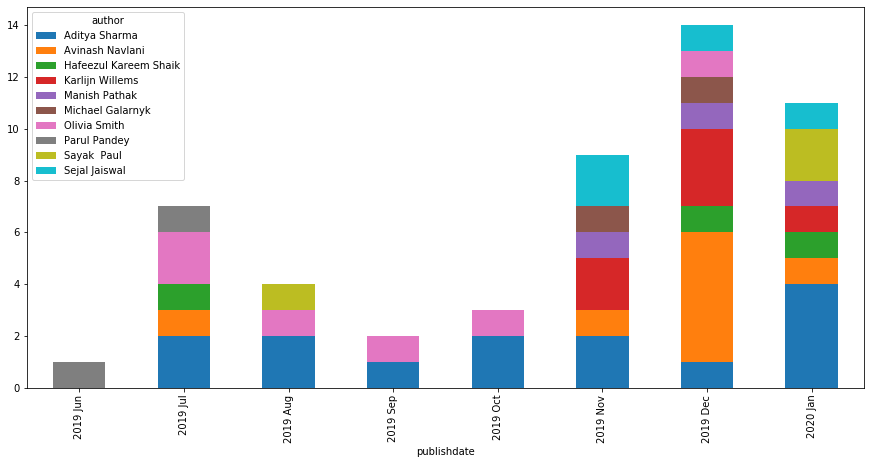

In [64]:
dhp = dh[dh["author"].isin(topauthors)].pivot_table(index="publishdate",values="posts",columns="author", aggfunc=np.sum)
fig, ax = plt.subplots(figsize=(15,7))
dhp.plot(ax=ax, kind='bar', stacked=True)
ticklabels = [item.strftime('%Y %b') for item in dhp.index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))

Debugged

There is no "Publishdateone" index in the DataFrame so it's Changed to "Publishdate"

Here is what we possibly get out of the above Chart along with considering the earlier visualization of Tutorial Counts by Authors.

While Karlijn Willems has been at the top for Tutorials count. 

She's also the first to start it all off!

Sejal Jaiswal while being the third by count, starts at a high pace and is being consistent with an average of 1 post a month.

Aditya Sharma might be crossing Sejal if the same pace is maintained in the coming time.


### Looking at Upvotes vs. Tutorials

When a reader likes a tutorial, an upvote is signaled respectively.

Let's see who's managed to get a good amount of upvotes vs. number of tutorials they have posted! 

We'll be considering the top 10 contributors in this case as well. This will be done by using a scatter plot.

In [65]:
upvotes = dh[dh["author"].isin(topauthors)].groupby(['author'], as_index=False).agg({'posts':"sum",      
                                     'upvote': "sum"})

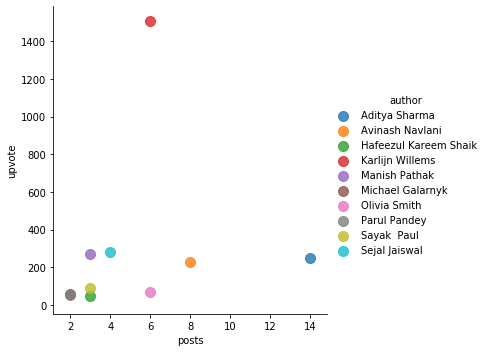

In [66]:
sns.lmplot('posts',
           'upvote',
           data=upvotes,
           fit_reg=False,
           hue="author",
           scatter_kws={"marker": "D",
                        "s": 100})

In [ ]:
<seaborn.axisgrid.FacetGrid at 0x1bd57cd69e8>

While Karlijn Willems has almost double the number of published posts, the number of upvotes are incredibly high! 

Around 3 times as much compared to Hugo's upvote count. 

Sejal has managed to be third while others have got some ground to cover to match the pace.

### Conclusion

In this tutorial, we have managed to achieve the following;

Scrape tutorials list across all pages.

Create a Data Frame and save it as CSV for later reference and Analysis.

Explored it using Pandas and Matplotlib along with some transformations.

Used Line, Bar, Stacked Bar and Scatter Plots to visualize.

I hope this gives a head start to many of us in exploring this and more data sets in a similar fashion!

If you would like to learn more about Python, take DataCamp's Introduction to Data Visualization with Python course and Importing Data in Python (Part 2) course to learn about BeautifulSoup.